# Predict Daily Bike Rentals

In this project, we will predict daily bike rentals based on various features like temperature, pressure, rainfall, holiday_ind and so on



In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and prepare the data

In [83]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [84]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

Plot to check number of rentals over the first 10 days


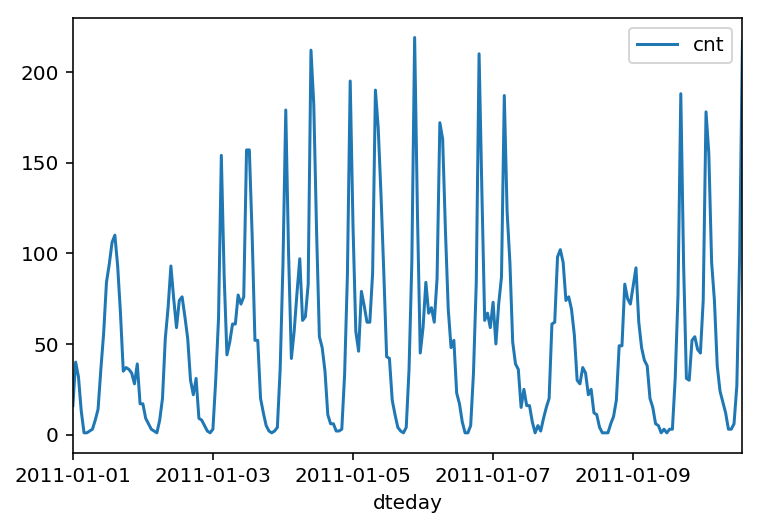

In [23]:
rides[:24*10].plot(x='dteday', y='cnt')

### Create Dummy variables for categorical data


In [24]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variable.

Standardize variables with mean 0 and standard deviation as 1 to remove impact of variables with high range values in the model


In [25]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets



In [26]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [31]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Neural Network Implementation

In [32]:
#############
# Import the Neural Network class from the neural_nets.py file
#############

from neural_nets import NeuralNetwork

In [33]:
#Calculate meas squared error
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [12]:
import sys

####################
### Network Hyper parameters are set in the neural_nets.py file ###
####################

from neural_nets import iterations, learning_rate, hidden_nodes, output_nodes

## Train data set features are Input to the neural net
N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Calculate the training loss and validation loss to check if model is overtfitting or underfitting
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 0.7% ... Training loss: 0.972 ... Validation loss: 1.367

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Progress: 99.9% ... Training loss: 0.303 ... Validation loss: 0.486

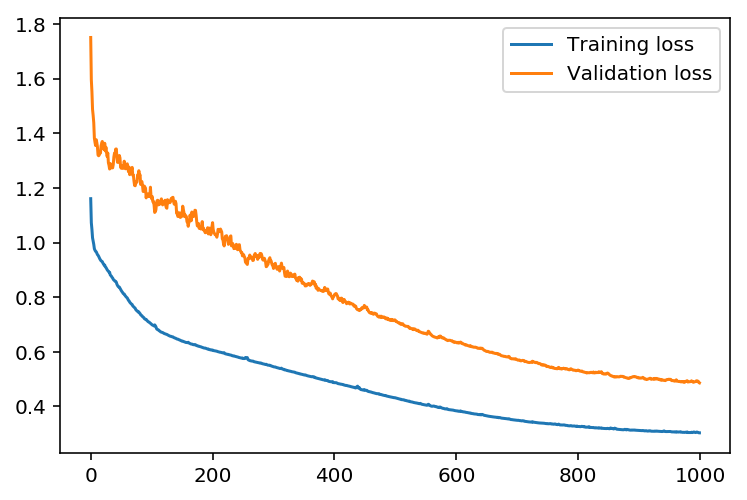

In [35]:
### The Graph looks good and doesnt overfit
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out the predictions on the test data 

The neural net was not able to predict well during the holiday season. More training and noise reduction like outlier detection and other data transformation steps are required to improve the predictions values


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


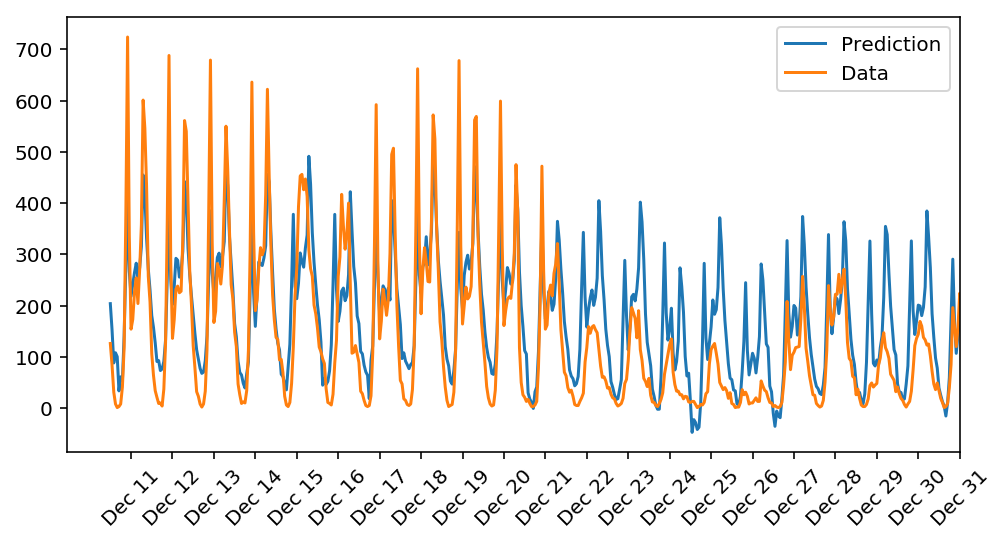

In [36]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Analyze more deeply how model performed across several dates

In [45]:
pred_df = pd.DataFrame(predictions).T
pred_df.columns = ['prediction_result']
pred_df.head()
pred_df.shape

(504, 1)

In [50]:
compare_df = pd.concat([test_targets.reset_index(drop=True), pred_df], axis=1)
compare_df['cnt'] = compare_df['cnt']*std + mean

In [ ]:
dftest = rides.ix[test_data.index]
df_final = dftest[['dteday','hr']]

In [72]:
df_fail = pd.concat([df_final.reset_index(drop=True),compare_df], axis = 1)

In [76]:
df_fail.head()

,dteday,hr,cnt,casual,registered,prediction_result,diff_pred
0,2012-12-10,22,126.0,-0.500481,-0.256260,203.761317,77.761317
1,2012-12-10,23,84.0,-0.561326,-0.513929,152.731831,68.731831
2,2012-12-11,0,31.0,-0.683018,-0.824452,88.016710,57.016710
3,2012-12-11,1,8.0,-0.703300,-0.969804,107.894350,99.894350
4,2012-12-11,2,1.0,-0.723582,-1.009445,100.285768,99.285768


In [75]:
df_fail['diff_pred'] = df_fail['prediction_result'] - df_fail['cnt'] 

### Model predicts we need 40 bikes more on average per day

In [78]:
df_fail['diff_pred'].describe()

count    504.000000
mean      39.639124
std       91.971241
min     -335.164111
25%        3.974147
50%       39.920959
75%       79.316949
max      321.400995
Name: diff_pred, dtype: float64

### In some of the cases model forecasts less vehicles then required, which is a bad sign since the biking company is going to loose lot of business

In [80]:
df_fail.sort_values(['diff_pred'])

,dteday,hr,cnt,casual,registered,prediction_result,diff_pred
202,2012-12-19,8,678.0,-0.459917,3.377526,342.835889,-335.164111
34,2012-12-12,8,688.0,-0.358507,3.410560,376.429087,-311.570913
10,2012-12-11,8,724.0,-0.399071,3.661622,412.860319,-311.139681
58,2012-12-13,8,679.0,-0.236816,3.311457,384.814418,-294.185582
178,2012-12-18,8,662.0,-0.520763,3.291636,393.132685,-268.867315
82,2012-12-14,8,636.0,-0.459917,3.100037,367.319986,-268.680014
226,2012-12-20,8,599.0,-0.439635,2.848975,394.541706,-204.458294
154,2012-12-17,8,592.0,-0.520763,2.829154,388.705909,-203.294091
134,2012-12-16,12,417.0,0.635306,1.296357,228.306463,-188.693537
111,2012-12-15,13,456.0,1.061226,1.415281,285.658099,-170.341901
